# Comparing UKBB and BioVU genome wide hits

-manhattan plots   
-any shared snps


In [1]:
import os, sys
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.colors
from datetime import datetime

from glob import glob 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
from IPython.core.display import display, HTML    
display(HTML("<style>.container {width:98% !important; }</style>"))
%matplotlib inline 
np.set_printoptions(precision=5, suppress=True) 

DATE = datetime.now().strftime('%Y-%m-%d')

In [2]:
import matplotlib.font_manager as fm
fpath='/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Arial.ttf'
prop = fm.FontProperties(fname=fpath, size=16)
bigprop = fm.FontProperties(fname=fpath, size=20)

In [3]:
sys.path.append("/dors/capra_lab/users/abraha1/bin/python_modules/assocplots")
from assocplots.manhattan import *

In [4]:
import rpy2.rinterface 
%load_ext rpy2.ipython

In [5]:
GWAS_P_THRESH = 5*10**-8
SUGG_GWAS_P_THRESH = 1*10**-6
MISS_P_THRESHOLD = 0.00001

In [6]:
# FILE PATHS 
BLAT_DIR="/dors/capra_lab/users/abraha1/prelim_studies/katja_biobank/data/blat_array_probes/uk_bv_blat_w_assoc_rsID/"

# BLAT: command line 
BLAT_RSID_UK = '/dors/capra_lab/users/abraha1/prelim_studies/katja_biobank/data/blat_array_probes/ukbb_probes/chrx_y_hits_only_UKBiLEVE_probes_blat.txt'
BLAT_RSID_UKW =  "/dors/capra_lab/users/abraha1/prelim_studies/katja_biobank/data/blat_array_probes/ukbb_probes/chrx_y_hits_only_UKBB_WCSF_probes_blat.txt"
BLAT_RSID_BV =  "/dors/capra_lab/users/abraha1/prelim_studies/katja_biobank/data/blat_array_probes/biovu_probes/chrx_y_hits_only_MEGAEx_probes_v1_blat.txt"

# WEBBLAT 
WEBBLAT_UKBIL="/dors/capra_lab/users/abraha1/prelim_studies/katja_biobank/data/blat_array_probes/ukbb_probes/web_blat/ukbil_w_score/chrxy_UKBil_probes_webscores.txt"
WEBBLAT_UKWCSF="/dors/capra_lab/users/abraha1/prelim_studies/katja_biobank/data/blat_array_probes/ukbb_probes/web_blat/ukwcsf_w_score/chrxy_ukwcsf_probes_webscores.txt"
WEBBLAT_BV="/dors/capra_lab/users/abraha1/prelim_studies/katja_biobank/data/blat_array_probes/biovu_probes/blat_psl/chrxy_MEGAx_probes_v1_blat_webscores.txt"

# GWAS SUMMARY STATS 
GWAS_DIR="/dors/capra_lab/users/abraha1/prelim_studies/katja_biobank/"
UK_GWAS_FILE = os.path.join(GWAS_DIR, "data/assoc_from_katja_2019_08_20/20190819_gwas_pca12_centers_age_FINAL.csv")
BV_GWAS_FILE = os.path.join(GWAS_DIR, "results/2019_07_21_logistic/2019_07_21_logistic.assoc.logistic")

# OUTPUT 
OUTPUT_DIR="/dors/capra_lab/users/abraha1/prelim_studies/katja_biobank/results/manuscript/manhattan_plots/manhattan_w_blat/"

# load 

In [7]:
# LOAD GWAS HITS 
raw_uk_df = pd.read_csv( UK_GWAS_FILE, sep=",")
raw_bv_df = pd.read_csv( BV_GWAS_FILE, sep="\s+")

# format results 
uk_gwas_df = raw_uk_df.loc[raw_uk_df.missing_p > MISS_P_THRESHOLD].copy() 
print("UKBB: Removed {:,} out of {:,} snps with singificant missingness b/w cases and controls.".format(raw_uk_df.shape[0] - uk_gwas_df.shape[0], raw_uk_df.shape[0]))
uk_gwas_df['chr_pos'] = uk_gwas_df.CHR.map(str) + ":" + uk_gwas_df.BP.map(str)

bv_gwas_df = raw_bv_df.loc[(raw_bv_df.TEST == "ADD") & (raw_bv_df.CHR < 23),].copy()
bv_gwas_df['chr_pos'] = bv_gwas_df.CHR.map(str) + ":" + bv_gwas_df.BP.map(str)

UKBB: Removed 28,714 out of 648,754 snps with singificant missingness b/w cases and controls.


In [8]:
uk_gwas_df['stat_sig'] = False
uk_gwas_df.loc[uk_gwas_df['P']< GWAS_P_THRESH, 'stat_sig'] = True

bv_gwas_df['stat_sig'] = False
bv_gwas_df.loc[bv_gwas_df['P']< GWAS_P_THRESH, 'stat_sig'] = True

In [9]:
# LOAD BLAT HTIS 
ukbil_blat_df = pd.read_csv(BLAT_RSID_UK, sep="\t")
ukw_blat_df = pd.read_csv(BLAT_RSID_UKW, sep="\t")
bv_blat_df = pd.read_csv(BLAT_RSID_BV, sep="\t")

ukbil_webblat_df = pd.read_csv(WEBBLAT_UKBIL, sep="\t", names=['targetChr','targetStart','targetEnd','queryName','score','per_identity'])
ukwcsf_webblat_df = pd.read_csv(WEBBLAT_UKWCSF, sep="\t", names=['targetChr','targetStart','targetEnd','queryName','score','per_identity'])
bv_webblat_df = pd.read_csv(WEBBLAT_BV, sep="\t", names=['targetChr','targetStart','targetEnd','queryName','score','per_identity'])

In [10]:
# format webblat resutls 
get_start = lambda x: int(x.split(":")[-1].split("-")[0])
get_end = lambda x: int(x.split(":")[-1].split("-")[1]) 


# add query start and end 
ukbil_webblat_df['q.start'] = ukbil_webblat_df.queryName.apply(get_start)
ukbil_webblat_df['q.end'] = ukbil_webblat_df.queryName.apply(get_end)

ukwcsf_webblat_df['q.start'] = ukwcsf_webblat_df.queryName.apply(get_start)
ukwcsf_webblat_df['q.end'] = ukwcsf_webblat_df.queryName.apply(get_end)

bv_webblat_df['q.start'] = bv_webblat_df.queryName.apply(get_start)
bv_webblat_df['q.end'] = bv_webblat_df.queryName.apply(get_end)

# add query length 
ukbil_blat_df['q.length'] = ukbil_blat_df['q.end'] -ukbil_blat_df['q.start'] +1
ukw_blat_df['q.length'] = ukw_blat_df['q.end'] -ukw_blat_df['q.start'] +1
bv_blat_df['q.length'] = bv_blat_df['q.end'] -bv_blat_df['q.start'] +1


ukbil_webblat_df['q.length'] = ukbil_webblat_df['q.end'] - ukbil_webblat_df['q.start']
ukwcsf_webblat_df['q.length'] = ukwcsf_webblat_df['q.end'] -ukwcsf_webblat_df['q.start']
bv_webblat_df['q.length'] = bv_webblat_df['q.end'] -bv_webblat_df['q.start']

In [11]:
# add bim_mapped_rsID
ukbil_blat_df['bim_mapped_rsID'] = ukbil_blat_df.QueryId.apply(lambda x: x.split(',')[-1])
ukw_blat_df['bim_mapped_rsID'] = ukw_blat_df.QueryId.apply(lambda x: x.split(',')[-1])
bv_blat_df['bim_mapped_rsID'] = bv_blat_df.QueryId.apply(lambda x: x.split(',')[1])

ukbil_webblat_df['bim_mapped_rsID'] = ukbil_webblat_df.queryName.apply(lambda x: x.split(',')[-1].split(":")[0])
ukwcsf_webblat_df['bim_mapped_rsID'] = ukwcsf_webblat_df.queryName.apply(lambda x: x.split(',')[-1].split(":")[0])
bv_webblat_df['bim_mapped_rsID'] = bv_webblat_df.queryName.apply(lambda x: x.split(',')[1])

# quality filter BLAT hits 

In [12]:
def bv_blat_filter(og_blat_df): 
    
    blat_df = og_blat_df.copy()
    
    qlength_bool = blat_df['q.length'] >= 40
    end_match_bool = blat_df['q.end'] == 50
    perID_bool = blat_df['per_identity'] >= 90

    blat_df['pass_blat_filters'] = qlength_bool  & end_match_bool & perID_bool

    return blat_df, og_blat_df

In [13]:
def uk_array_filter(blat_df, webblat=False):
    temp_uk_df = blat_df.copy()
    
    if webblat: 
        qendt = 35
    else:
        qendt = 36
    
    # webblat is 0 start 
        
    uk_qlength_bool = temp_uk_df['q.length'] >= 40
    incl_center_bool = (temp_uk_df['q.end'] > qendt) & (temp_uk_df['q.start'] < qendt) 
    uk_perID_bool = temp_uk_df['per_identity'] >= 90


    temp_uk_df['pass_blat_filters'] = uk_qlength_bool  & incl_center_bool & uk_perID_bool
    
    return temp_uk_df, blat_df


# UKBB: 
#    REQUIRE: at least 40 bp overlap 
#    REQUIRE: match to the middle of the query 
#    REQUIRE: 90% per ID

In [14]:
# ---- BLAT WITH WEB SETTINGS ---
# FILTER OUT BAD BLAT HITS 


# BV WEBBLAT 
bv_webblat_df, all_bv_webblat_df = bv_blat_filter(bv_webblat_df)


# UK WEBBLAT 
ukbil_webblat_df, all_ukbil_webblat_df = uk_array_filter(ukbil_webblat_df, webblat=True)
ukwcsf_webblat_df, all_ukwcsf_webblat_df = uk_array_filter(ukwcsf_webblat_df, webblat=True)


pd.value_counts(bv_webblat_df.pass_blat_filters)
pd.value_counts(ukbil_webblat_df.pass_blat_filters)
pd.value_counts(ukwcsf_webblat_df.pass_blat_filters)

False    1844895
True     1030168
Name: pass_blat_filters, dtype: int64

False    1597535
True      376650
Name: pass_blat_filters, dtype: int64

False    1628348
True      400126
Name: pass_blat_filters, dtype: int64

In [15]:
# number of variants that have ≥1 X or Y hit that pass the above threshold 

print("NUMBER OF VARIANTS WITH ≥1 'HIGH QUALITY' X or Y MATCH")
print("\n")
print("bv : {:,} out of {:,}".format(bv_webblat_df.loc[bv_webblat_df['pass_blat_filters']==True, 'bim_mapped_rsID'].nunique(),
                                     bv_webblat_df.bim_mapped_rsID.nunique()))

# uk bileve 
print("uk bileve:")
ukbil_webblat_df.bim_mapped_rsID.nunique()
ukbil_webblat_df.loc[ukbil_webblat_df['pass_blat_filters']==True, 'bim_mapped_rsID'].nunique()

print("ukwcsf:")
ukwcsf_webblat_df.bim_mapped_rsID.nunique()
ukwcsf_webblat_df.loc[ukwcsf_webblat_df['pass_blat_filters']==True, 'bim_mapped_rsID'].nunique()


NUMBER OF VARIANTS WITH ≥1 'HIGH QUALITY' X or Y MATCH


bv : 57,710 out of 234,450
uk bileve:


145876

33105

ukwcsf:


148427

33634

In [16]:
# BV COMMAND LINE BLAT 
bv_blat_df, _ = bv_blat_filter(bv_blat_df)

# UK COMMAND LINE BLAT 
ukbil_blat_df, _  = uk_array_filter(ukbil_blat_df)
ukw_blat_df, _  = uk_array_filter(ukw_blat_df)

pd.value_counts(bv_blat_df.pass_blat_filters)
pd.value_counts(ukbil_blat_df.pass_blat_filters)
pd.value_counts(ukw_blat_df.pass_blat_filters)

True     505313
False    421999
Name: pass_blat_filters, dtype: int64

False    222075
True     101621
Name: pass_blat_filters, dtype: int64

False    227283
True     111250
Name: pass_blat_filters, dtype: int64

In [17]:
# pick best BLAT hit per SNP tested 
def pick_best_blat(blat_df, blat_filter=True): 
    temp_blat_df = blat_df.copy()
    
    
    if blat_filter: 
        good_blat_hits = temp_blat_df.loc[temp_blat_df['pass_blat_filters']==True].reset_index(drop=True)
    else: 
        good_blat_hits = temp_blat_df.reset_index(drop=True)
        
    best_df = good_blat_hits.loc[good_blat_hits.groupby('bim_mapped_rsID')['per_identity'].idxmax()].reset_index(drop=True)
    
    return best_df

In [18]:
# PICK THE BEST BLAT HIT 

# pool both uk arrays 
both_uk_blat_df = pd.concat([ukbil_blat_df, ukw_blat_df], axis=0)
both_uk_webblat_df = pd.concat([ukbil_webblat_df, ukwcsf_webblat_df],axis=0)

#
# Command line Blat 
#

# filter and keep only best BLAT hits 
uk_best_blast_df = pick_best_blat(both_uk_blat_df)
bv_best_blast_df = pick_best_blat(bv_blat_df)

# don't filter BLAT hits... 
uk_no_filt_best_blast_df = pick_best_blat(both_uk_blat_df, blat_filter=False)
bv_no_filt_best_blast_df = pick_best_blat(bv_blat_df, blat_filter=False)

#
# WEBBLAT 
#

uk_best_webblast_df = pick_best_blat(both_uk_webblat_df)
bv_best_webblast_df = pick_best_blat(bv_webblat_df)

uk_no_filt_best_webblast_df = pick_best_blat(both_uk_webblat_df, blat_filter=False)
bv_no_filt_best_webblast_df = pick_best_blat(bv_webblat_df, blat_filter=False)

In [19]:
# check the number of X and Y hits before filtering w/ BLAT criteria 
uk_sig_snps = uk_gwas_df.loc[uk_gwas_df['stat_sig']==True, 'SNP'].values
bv_sig_snps = bv_gwas_df.loc[bv_gwas_df['stat_sig']==True, 'SNP'].values

print("UK: ")
len(uk_sig_snps)
uk_best_blast_df[uk_best_blast_df.bim_mapped_rsID.isin(uk_sig_snps)].shape
uk_no_filt_best_blast_df[uk_no_filt_best_blast_df.bim_mapped_rsID.isin(uk_sig_snps)].shape

uk_best_webblast_df[uk_best_webblast_df.bim_mapped_rsID.isin(uk_sig_snps)].shape
uk_no_filt_best_webblast_df[uk_no_filt_best_webblast_df.bim_mapped_rsID.isin(uk_sig_snps)].shape

print("BV: ")
len(bv_sig_snps)
bv_best_blast_df[bv_best_blast_df.bim_mapped_rsID.isin(bv_sig_snps)].shape
bv_no_filt_best_blast_df[bv_no_filt_best_blast_df.bim_mapped_rsID.isin(bv_sig_snps)].shape

bv_best_webblast_df[bv_best_webblast_df.bim_mapped_rsID.isin(bv_sig_snps)].shape
bv_no_filt_best_webblast_df[bv_no_filt_best_webblast_df.bim_mapped_rsID.isin(bv_sig_snps)].shape


UK: 


8

(4, 15)

(6, 15)

(7, 11)

(8, 11)

BV: 


5

(2, 15)

(2, 15)

(5, 11)

(5, 11)

# merge blat hits with association hits

In [20]:
def merge_blat_and_gwas(blat_df , gwas_df):
    # merge UKBB gwas with BLAT hits
    to_merge_df = blat_df.copy()
    to_merge_df['target_Start-End'] = to_merge_df.targetStart.map(str) + "-" + to_merge_df.targetEnd.map(str)
    to_merge_df['query_Start-End'] = to_merge_df['q.start'].map(str) + "-" + to_merge_df['q.end'].map(str)
    keep_cols = ['targetChr','target_Start-End', 'per_identity','query_Start-End', 'q.length','bim_mapped_rsID','pass_blat_filters']

    merged_df = pd.merge(gwas_df, to_merge_df.loc[:, keep_cols], left_on = "SNP", right_on="bim_mapped_rsID", how='left')
    
    print(f"Out of {blat_df.bim_mapped_rsID.nunique():,} SNPs with X or Y hits,")
    print(f"{(~merged_df.bim_mapped_rsID.isna()).sum():,}, SNPs in the GWAS summary stats were mapped.")
    
    return merged_df

In [21]:
uk_gwas_blat_df = merge_blat_and_gwas(uk_best_webblast_df, uk_gwas_df)
print("--")
bv_gwas_blat_df = merge_blat_and_gwas(bv_best_webblast_df, bv_gwas_df)

Out of 34,606 SNPs with X or Y hits,
28,555, SNPs in the GWAS summary stats were mapped.
--
Out of 57,710 SNPs with X or Y hits,
4,994, SNPs in the GWAS summary stats were mapped.


In [22]:
uk_gwas_df.shape
bv_gwas_df.shape

uk_gwas_blat_df.head()
bv_gwas_blat_df.shape

(620040, 12)

(798051, 11)

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P,missing_p,chr_pos,stat_sig,targetChr,target_Start-End,per_identity,query_Start-End,q.length,bim_mapped_rsID,pass_blat_filters
0,1,rs116587930,727841,A,ADD,429902,1.0020,0.1803,0.85690,0.225600,1:727841,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,rs116720794,729632,T,ADD,456494,0.9791,-1.8780,0.06035,0.002207,1:729632,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,rs3131972,752721,A,ADD,475137,1.0030,0.5309,0.59550,0.299300,1:752721,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,rs12184325,754105,T,ADD,477138,0.9850,-1.3720,0.17000,0.725300,1:754105,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,rs3131962,756604,A,ADD,476739,1.0060,0.9662,0.33390,0.786000,1:756604,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(798051, 18)

## merge blat hits with snps with high missingness rate between casses and controls

In [23]:
uk_gwas_df.head()

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P,missing_p,chr_pos,stat_sig
0,1,rs116587930,727841,A,ADD,429902,1.0020,0.1803,0.85690,0.225600,1:727841,False
1,1,rs116720794,729632,T,ADD,456494,0.9791,-1.8780,0.06035,0.002207,1:729632,False
2,1,rs3131972,752721,A,ADD,475137,1.0030,0.5309,0.59550,0.299300,1:752721,False
3,1,rs12184325,754105,T,ADD,477138,0.9850,-1.3720,0.17000,0.725300,1:754105,False
4,1,rs3131962,756604,A,ADD,476739,1.0060,0.9662,0.33390,0.786000,1:756604,False


In [24]:
raw_uk_df.head()

uk_missingness_df= raw_uk_df.loc[ (raw_uk_df['missing_p']<MISS_P_THRESHOLD) & (raw_uk_df['P']<GWAS_P_THRESH) ].copy()
uk_missingness_df.loc[uk_missingness_df['P']< GWAS_P_THRESH, 'stat_sig'] = True
uk_missingness_df['chr_pos'] = uk_missingness_df.CHR.map(str) + ":" + uk_missingness_df.BP.map(str)

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P,missing_p
0,1,rs116587930,727841,A,ADD,429902,1.0020,0.1803,0.85690,0.225600
1,1,rs116720794,729632,T,ADD,456494,0.9791,-1.8780,0.06035,0.002207
2,1,rs3131972,752721,A,ADD,475137,1.0030,0.5309,0.59550,0.299300
3,1,rs12184325,754105,T,ADD,477138,0.9850,-1.3720,0.17000,0.725300
4,1,rs3131962,756604,A,ADD,476739,1.0060,0.9662,0.33390,0.786000


In [25]:
uk_gwas_misssingness_blat_df = merge_blat_and_gwas(uk_best_webblast_df, uk_missingness_df)

Out of 34,606 SNPs with X or Y hits,
38, SNPs in the GWAS summary stats were mapped.


In [26]:
uk_gwas_misssingness_blat_df.loc[uk_gwas_misssingness_blat_df['pass_blat_filters']==True].SNP.nunique()

38

In [27]:
uk_gwas_misssingness_blat_df.drop(columns=['CHR','BP','TEST','STAT','stat_sig','bim_mapped_rsID'], inplace=True)

In [45]:
uk_gwas_misssingness_blat_df.sort_values('pass_blat_filters', inplace=True)

In [46]:
write_out="/dors/capra_lab/users/abraha1/prelim_studies/katja_biobank/results/manuscript/tables/ukbb_snps_w_differential_missingness_and_blat_to_x_y.tsv"
uk_gwas_misssingness_blat_df.to_csv(write_out, sep="\t",index=False)

# plot of BLAT hits

In [41]:
# -- dictionary mapping SNP to whether it is GWAS SIGNIFICANT 

uksig_dict = dict(zip(uk_gwas_df.SNP, uk_gwas_df.stat_sig))
bvsig_dict = dict(zip(bv_gwas_df.SNP, bv_gwas_df.stat_sig))


,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P,missing_p,chr_pos,stat_sig
0,1,rs116587930,727841,A,ADD,429902,1.0020,0.1803,0.85690,0.225600,1:727841,False
1,1,rs116720794,729632,T,ADD,456494,0.9791,-1.8780,0.06035,0.002207,1:729632,False
2,1,rs3131972,752721,A,ADD,475137,1.0030,0.5309,0.59550,0.299300,1:752721,False
3,1,rs12184325,754105,T,ADD,477138,0.9850,-1.3720,0.17000,0.725300,1:754105,False
4,1,rs3131962,756604,A,ADD,476739,1.0060,0.9662,0.33390,0.786000,1:756604,False


In [42]:
# map gwas significant to BLAT hits 
all_bv_webblat_df['stat_sig'] = all_bv_webblat_df.bim_mapped_rsID.map(bvsig_dict)
all_ukwcsf_webblat_df['stat_sig'] = all_ukwcsf_webblat_df.bim_mapped_rsID.map(uksig_dict)
all_ukbil_webblat_df['stat_sig'] = all_ukbil_webblat_df.bim_mapped_rsID.map(uksig_dict)



In [44]:
all_bv_webblat_df.head()

,targetChr,targetStart,targetEnd,queryName,score,per_identity,q.start,q.end,q.length,bim_mapped_rsID,stat_sig
0,chrX,140803349,140803401,"seqA,1:100183042-AG,1,100183042,T,C:0-45",30,91.7,0,45,45,1:100183042-AG,NaN
1,chrY,8786480,8786530,"seqA,1:100288935-T-C,0,0,A,G:0-50",48,98.0,0,50,50,1:100288935-T-C,NaN
2,chrY,16112985,16113030,"seqA,1:100288935-T-C,0,0,A,G:0-45",43,97.8,0,45,45,1:100288935-T-C,NaN
3,chrY,59240771,59240820,"seqA,1:100288935-T-C,0,0,A,G:0-49",43,93.9,0,49,49,1:100288935-T-C,NaN
4,chrY,14565576,14565777,"seqA,1:100288935-T-C,0,0,A,G:0-50",43,93.9,0,50,50,1:100288935-T-C,NaN


In [57]:
def perm_by_rsid(sig_ids, nsig_ids, df, num_iters=1000, seed=20, test_col='log_evalue'): 
    """
    permutation test for difference in mean of 'test_col'. 
    
    This is implemented such that the rsID are shuffled between 'significant' and 'non-significant' labels. 
    This way a SNP can have mulitple BLAT hits and all of those blat hits will have the label assigned to that snp. 
    
    """
    
    
    sig_mean = df.loc[df.bim_mapped_rsID.isin(sig_ids), test_col].mean()
    nsig_mean = df.loc[df.bim_mapped_rsID.isin(nsig_ids), test_col].mean()
    
    # one way test that sig_mean > nsig_mean 
    # Ho: true_diff == 0 
    # Ha: true_diff > 0 
    true_diff = sig_mean - nsig_mean 
    
    rng = np.random.RandomState(seed)
    
    pooled_ids = list(sig_ids.union(nsig_ids))
    len_sig = len(sig_ids)
    len_nsig = len(nsig_ids)
    print("Running {:,} iterations.".format(num_iters))
    print("sig = {}, n_nsig = {}".format(len_sig, len_nsig))
    
    all_nulls = [] 
    for i in range(num_iters):
        print(i) if (i % 1000 == 0) else None
        
        rng.shuffle(pooled_ids)
        new_sig, new_nsig = pooled_ids[:len_sig], pooled_ids[len_sig:]
    
        sig_mean = df.loc[df.bim_mapped_rsID.isin(new_sig), test_col].mean()
        nsig_mean = df.loc[df.bim_mapped_rsID.isin(new_nsig), test_col].mean()


        null_val = sig_mean - nsig_mean
        all_nulls.append(null_val)

    return [np.sum(all_nulls > true_diff) / len(all_nulls), all_nulls, true_diff]

In [65]:
def calc_perID_pvalue(df):
#     df = all_bv_webblat_df
    mapped_df = df.loc[~df.stat_sig.isna()].copy()

    sig_snps = set(mapped_df.loc[mapped_df['stat_sig']==True, 'bim_mapped_rsID'].unique())
    unsig_snps = set(mapped_df.loc[mapped_df['stat_sig']==False, 'bim_mapped_rsID'].unique())

    pval, nulls, true_diff = perm_by_rsid(sig_snps, unsig_snps, mapped_df, num_iters=1000, seed=20, test_col='per_identity')
    
    return pval

In [66]:

bv_pval = calc_perID_pvalue(all_bv_webblat_df)
ukw_pval = calc_perID_pvalue(all_ukwcsf_webblat_df)
ukbb_pval = calc_perID_pvalue(all_ukbil_webblat_df)

Running 1,000 iterations.
sig = 5, n_nsig = 83078
0
Running 1,000 iterations.
sig = 8, n_nsig = 128082
0
Running 1,000 iterations.
sig = 8, n_nsig = 128082
0


In [67]:
bv_pval
ukw_pval
ukbb_pval

0.394

0.901

0.901

In [51]:
all_bv_webblat_df.loc[all_bv_webblat_df['stat_sig']==True].per_identity.mean()
all_bv_webblat_df.loc[all_bv_webblat_df['stat_sig']==False].per_identity.mean()

96.14

94.51270659340072

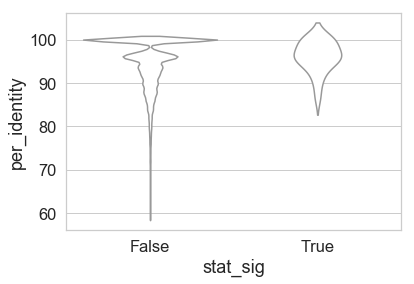

In [49]:
sns.set(style="whitegrid", font_scale=1.5)
# sns.stripplot(data=all_bv_webblat_df, x="stat_sig", y="per_identity", alpha=1, size=4)
# sns.boxplot(data=all_bv_webblat_df, x="stat_sig", y="per_identity", color="white")
sns.violinplot(data=all_bv_webblat_df, x="stat_sig", y="per_identity", color="white", inner=None)

In [41]:
uk_gwas_blat_df.loc[uk_gwas_blat_df['stat_sig']]

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P,missing_p,chr_pos,stat_sig,targetChr,target_Start-End,per_identity,query_Start-End,q.length,bim_mapped_rsID,pass_blat_filters
29591,1,rs75745570,162075684,T,ADD,471060,0.9231,-7.477,7.601000e-14,0.010980,1:162075684,True,chrX,121952043-121952114,90.2,0-71,71.0,rs75745570,True
159368,4,rs114928327,88457099,T,ADD,413257,0.8924,-9.669,4.088000e-22,0.000064,4:88457099,True,chrX,79401701-79401751,95.9,0-50,50.0,rs114928327,True
366092,10,rs11598874,39006198,T,ADD,478329,1.0720,7.039,1.937000e-12,0.105000,10:39006198,True,chrY,13568059-13568130,97.2,0-71,71.0,rs11598874,True
388436,11,rs11032483,4515024,T,ADD,482581,1.2540,15.410,1.329000e-53,0.053430,11:4515024,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
395906,11,rs75212444,34104213,T,ADD,482788,0.8822,-7.327,2.353000e-13,0.002453,11:34104213,True,chrX,36967486-36967536,96.0,5-55,50.0,rs75212444,True
442574,12,rs7298104,118926685,T,ADD,475771,0.9115,-6.191,5.966000e-10,0.093570,12:118926685,True,chrX,140960243-140960716,97.3,19-67,48.0,rs7298104,True
581948,19,rs116890400,53535248,A,ADD,485047,0.8810,-6.803,1.023000e-11,0.000012,19:53535248,True,chrX,69087775-69087830,91.0,16-71,55.0,rs116890400,True
601395,21,rs73196350,18068575,A,ADD,479137,0.9356,-6.213,5.187000e-10,0.005081,21:18068575,True,chrX,45477211-45477251,94.9,24-64,40.0,rs73196350,True


In [42]:
bv_gwas_blat_df.loc[bv_gwas_blat_df['stat_sig']]

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P,chr_pos,stat_sig,targetChr,target_Start-End,per_identity,query_Start-End,q.length,bim_mapped_rsID,pass_blat_filters
137217,3,JHU_3.16652239,16652240,T,ADD,61709,1.3080,19.330,2.825000e-83,3:16652240,True,chrY,26964471-26964521,96.0,0-50,50.0,JHU_3.16652239,True
376986,7,rs145369881,100351596,T,ADD,60499,0.7808,-5.527,3.251000e-08,7:100351596,True,chrX,66853761-66853802,95.2,9-50,41.0,rs145369881,True
381749,7,rs77638744,121147858,A,ADD,61361,1.1230,6.403,1.522000e-10,7:121147858,True,chrY,23315613-23316169,98.0,0-50,50.0,rs77638744,True
586154,13,JHU_13.20119335,20119336,C,ADD,61694,1.1850,11.700,1.265000e-31,13:20119336,True,chrY,28612640-28612689,91.9,0-50,50.0,JHU_13.20119335,True
620037,14,14:35761675-C-G,35761675,G,ADD,61712,1.1620,9.266,1.935000e-20,14:35761675,True,chrY,15398460-15398510,96.0,0-50,50.0,14:35761675-C-G,True
